In [1]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
# import Optimiser as Opt
# importlib.reload(Opt)
import timeit
from scipy.optimize import curve_fit
import json
import pandas as pd

# Normal ORCA

In [2]:
import AtomicConstants as AC
importlib.reload(AC)

# Make atom class

config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 5, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [4]:
pd.read_csv("Rb//Rb1MatrixElements.csv")

,Initial,Final,Wavelength (nm),Wavelength error (nm),Wavelength (nm).1,Matrix element (a.u.),Matrix el. error (a.u.),Matrix element (a.u.).1,Reference,DOI,Reference 2,DOI 2
0,5s1/2,5p1/2,794.9789,0.0006,794.9789(6),4.231000,0.003000,4.231(3),"U. Volz and H. Schmoranzer, Physica Scripta T6...",https://doi.org/10.1088/0031-8949/1996/T65/007,NaN,NaN
1,5s1/2,5p3/2,780.2415,0.0006,780.2415(6),5.978000,0.005000,5.978(5),"U. Volz and H. Schmoranzer, Physica Scripta T6...",https://doi.org/10.1088/0031-8949/1996/T65/007,NaN,NaN
2,5s1/2,6p1/2,421.6726,0.0003,421.6726(3),0.323500,0.000900,0.3235(9),"C. D. Herold, V. D. Vaidya, X. Li, S. L. Rolst...",https://doi.org/10.1103/PhysRevLett.109.243003,NaN,NaN
3,5s1/2,6p3/2,420.2989,0.0002,420.2989(2),0.523000,0.000800,0.5230(8),"C. D. Herold, V. D. Vaidya, X. Li, S. L. Rolst...",https://doi.org/10.1103/PhysRevLett.109.243003,NaN,NaN
4,5s1/2,7p1/2,359.2597,0.0002,359.2597(2),0.115430,0.008061,0.1154(81),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
598,12d5/2,9f7/2,25419.4204,34.7961,25420(30)*,24.224431,0.168098,24.22(17),NaN,NaN,NaN,NaN
599,12d5/2,10f5/2,74211.5028,280.8207,74200(300)*,29.274806,1.034787,29.3(10),NaN,NaN,NaN,NaN
600,12d5/2,10f7/2,74205.9958,280.7790,74200(300)*,130.913700,4.628250,130.9(46),NaN,NaN,NaN,NaN
601,12d5/2,11f5/2,176740.8978,1592.7983,1.77(2)E+05*,66.745112,0.710233,66.75(71),NaN,NaN,NaN,NaN


## 10ns storage

<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:61: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_395713/553445534.py:61: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel('(1/$\gamma$)')


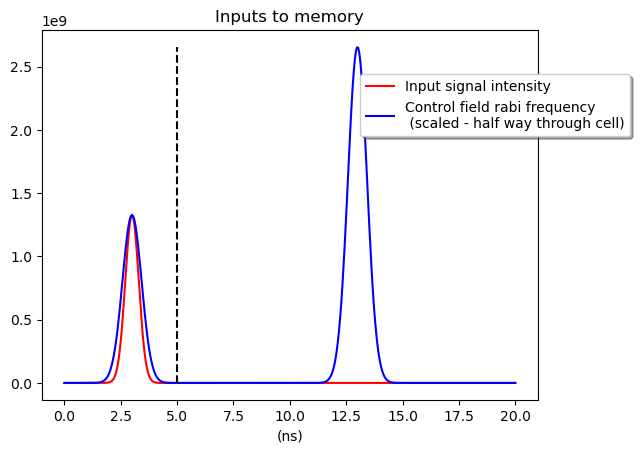

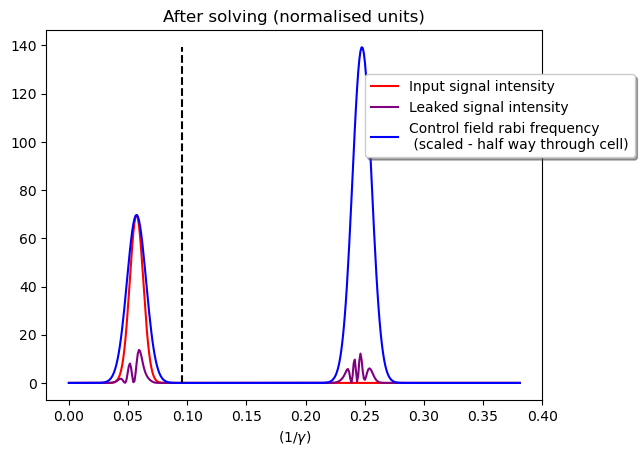

Storage Efficiency = 0.840290095204812
Total Efficiency = 0.1368028775819972


In [10]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'


OD = 100000 # Optical depth
#BW = 2*np.pi*1e9
tau = 1e-9 # FWHM of signal pulse
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9 # detuning from intermediate state

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau # centre of first signal pulse
tend = 20e-9
tbounds = np.array([0, tend])

m = 400 # number of time steps
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #polarization of photon
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] # input signal

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 10e-9 # storage time
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store) # control field for storage
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve) # control field for retrieval
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

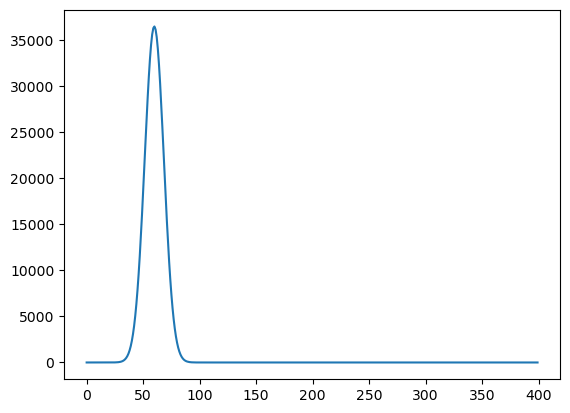

In [17]:
plt.plot(Einits[:,0])

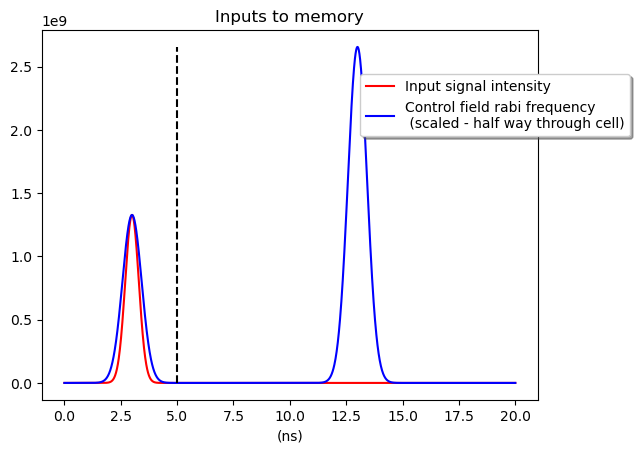

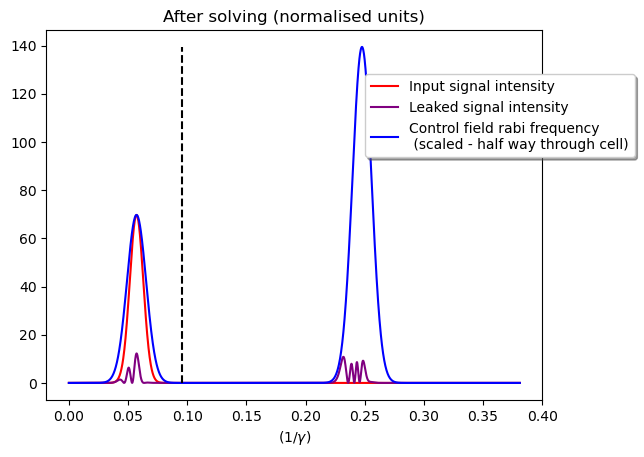

Storage Efficiency = 0.8874987184972957
Total Efficiency = 0.14137814966303208


In [16]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 20e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 10e-9 # storage time
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

## 18ns storage time

<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:61: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_395713/1661275446.py:61: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel('(1/$\gamma$)')


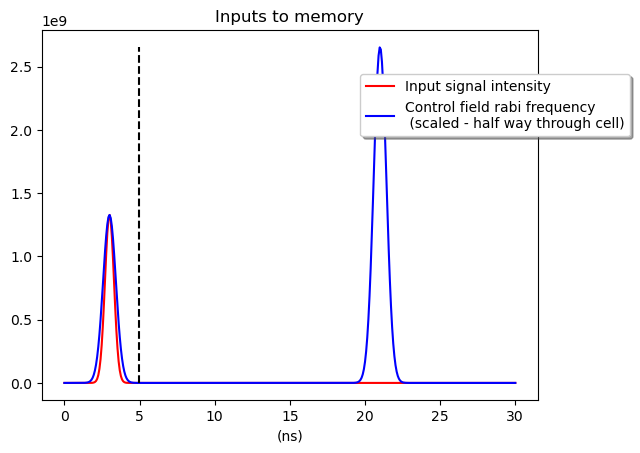

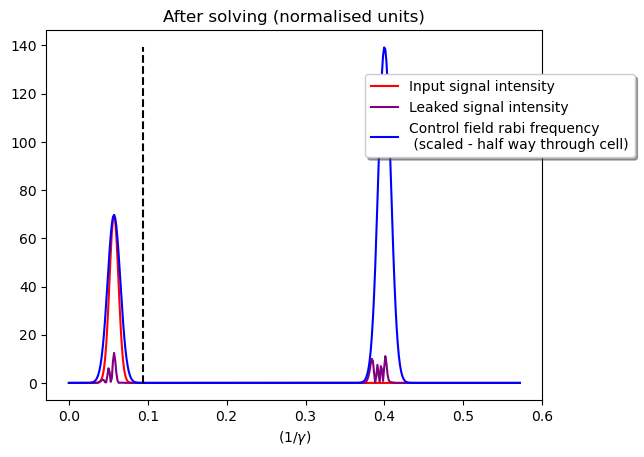

Storage Efficiency = 0.8853442689391388
Total Efficiency = 0.1438746955234704


In [8]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 30e-9
tbounds = np.array([0, tend])

m = 400
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 18e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

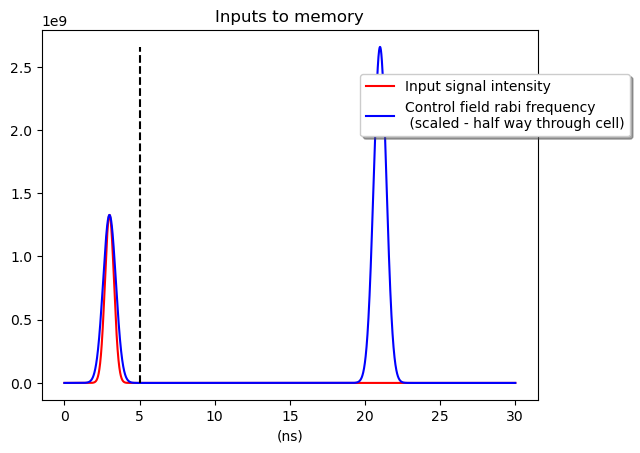

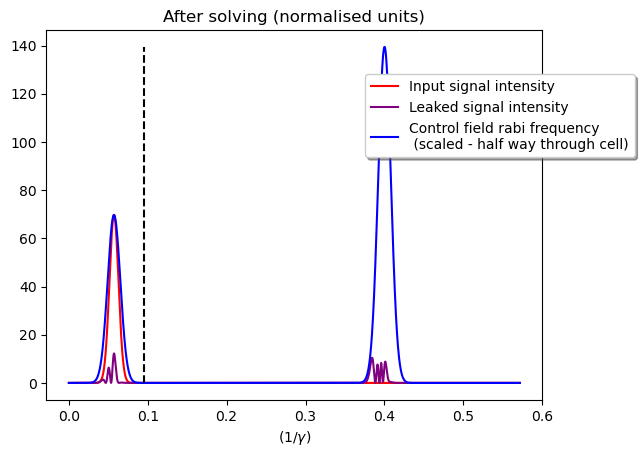

Storage Efficiency = 0.8875336186382933
Total Efficiency = 0.13609704128090266


In [20]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 30e-9
tbounds = np.array([0, tend])

m = 5000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 18e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

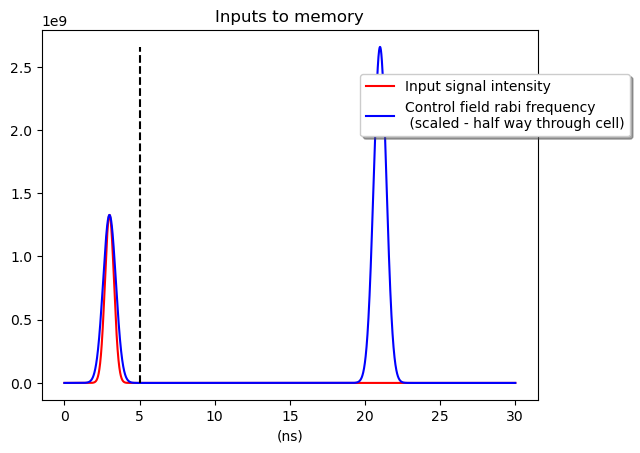

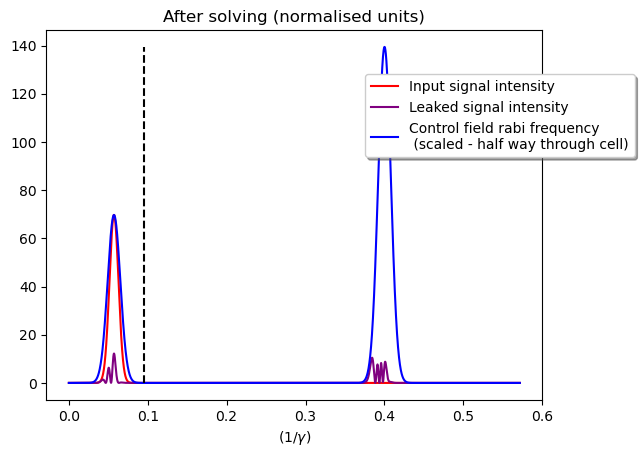

Storage Efficiency = 0.8914373715556446
Total Efficiency = 0.13552487432225768


In [21]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'

OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 50
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 30e-9
tbounds = np.array([0, tend])

m = 5000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 1e10
tr = 18e-9
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

## Improve retrieval

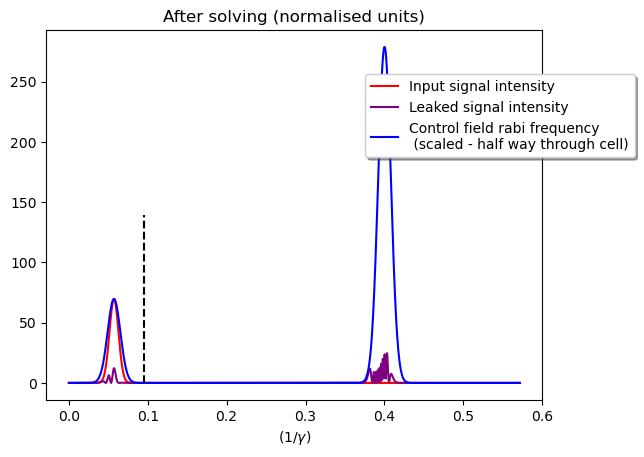

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.27875580966623353


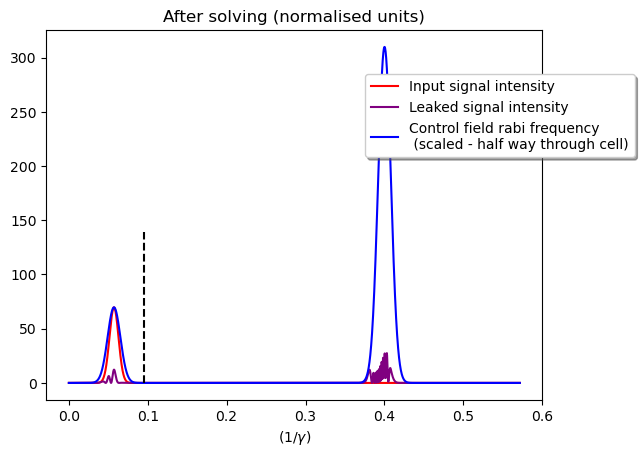

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.318817163067441


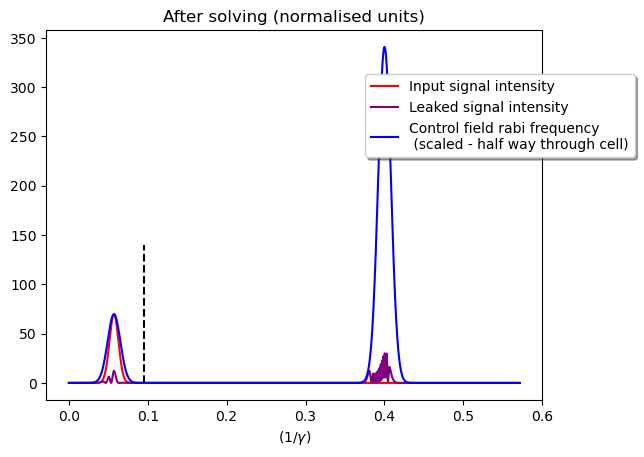

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.3396590571558892


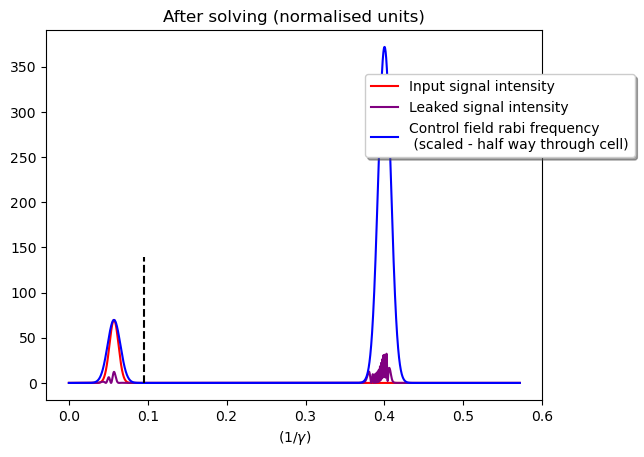

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.3494002559454366


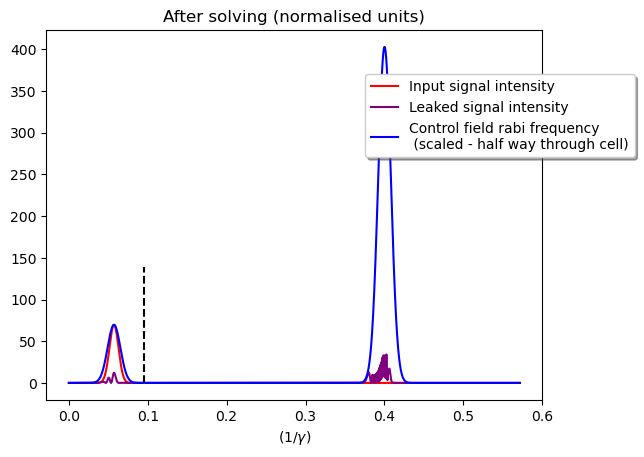

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.35547334535970787


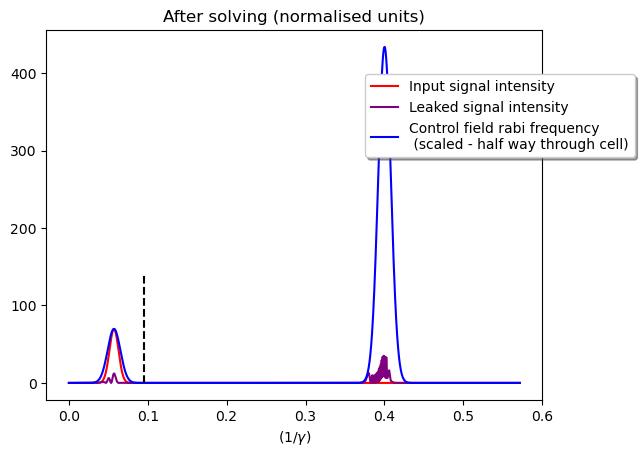

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.36122373623216414


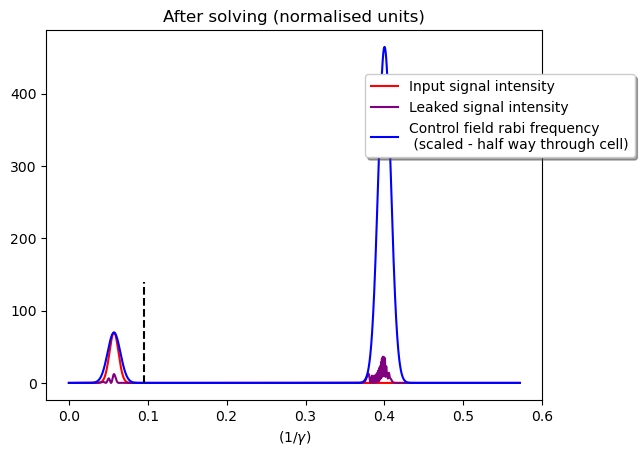

Storage Efficiency = 0.8875328307519343
Total Efficiency = 0.3698397059363421


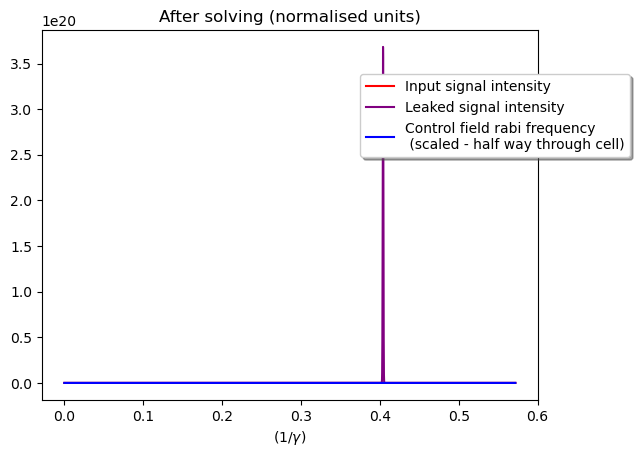

Storage Efficiency = 0.8875328307519343
Total Efficiency = 3.9102029017507974e+17


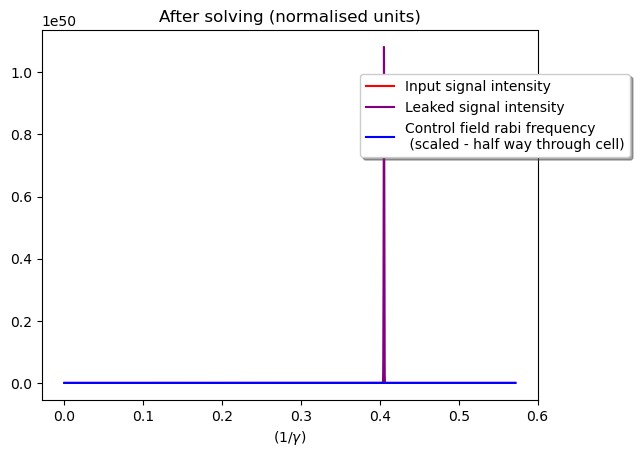

Storage Efficiency = 0.8875328307519343
Total Efficiency = 1.0054208509661026e+47


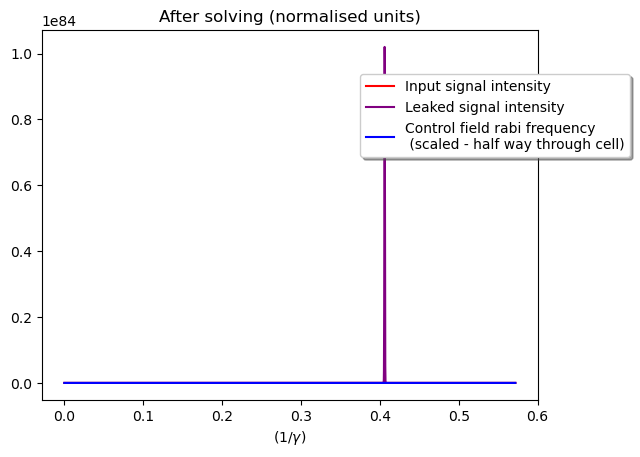

Storage Efficiency = 0.8875328307519343
Total Efficiency = 8.755808886452104e+80


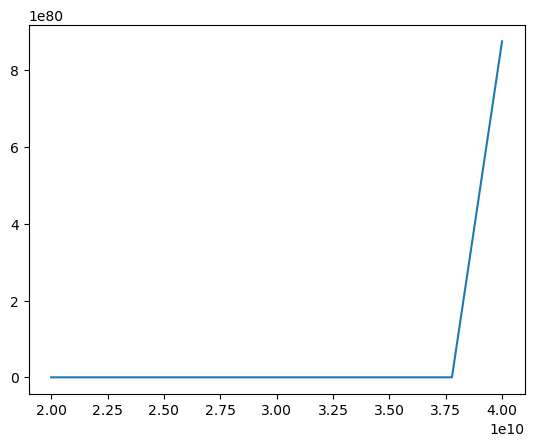

In [32]:
import MEVeS as S
importlib.reload(S)

protocol = 'ORCA'

OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 400
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 30e-9
tbounds = np.array([0, tend])

m = 4000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9

Omega_retrieve_list = np.linspace(2e10, 4e10, 10)
eff_list = []

for Omega_retrieve in Omega_retrieve_list:
    tr = 18e-9
    control_pol = np.array([1, 0])
    Control_store = S.gaussian(t, t0, tau, Omega_store)
    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    mcut = int((t0+2*tau)*m/(tend))

    # plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
    # plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    # plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
    # plt.title('Inputs to memory')
    # plt.xlabel('(ns)')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    # plt.show()

    sol.solve(Control_tzp, method='RK4-Ralston')

    plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
    plt.title('After solving (normalised units)')
    plt.xlabel('(1/$\gamma$)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

    eff = sol.storage_efficiency(sol.S, mcut)

    print("Storage Efficiency = " + str(eff))

    eff = sol.retrieval_efficiency(sol.E, mcut, 0)

    print("Total Efficiency = " + str(eff))

    eff_list.append(eff)

plt.plot(Omega_retrieve_list, eff_list)
plt.show()

## Efficiency vs storage time

In [150]:
# Make atom class

config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 5, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [151]:
def gaussian_fit(t, tw, A):
    return A*np.exp(-pow(t,2)/(2*pow(tw,2)))

In [155]:
# expected lifetime
T = 273.15 + 100

kr = abs(atom.wavevectors[0] - atom.wavevectors[1])
vmean = np.sqrt(sol.kB*T/atom.mass)

tDoppler = 1/(kr*vmean)
print(tDoppler*1e9)

119.66575554547389


In [156]:
tDecoherence = 1/atom.gammas[1]
print(tDecoherence*1e9)

702.9704593339245


In [157]:
atom.lifetimes

array([2.62402923e-08, 3.51485230e-07])

In [158]:
1/atom.lifetimes

array([38109331.60238767,  2845069.76565563])

In [159]:
(1/atom.lifetimes)*1/(2*np.pi)

array([6065288.50244818,  452806.91664539])

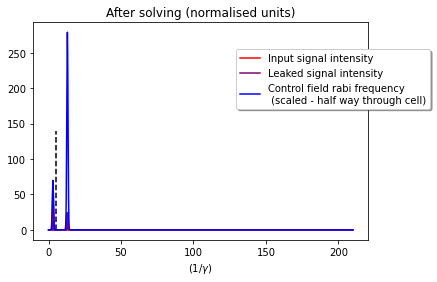

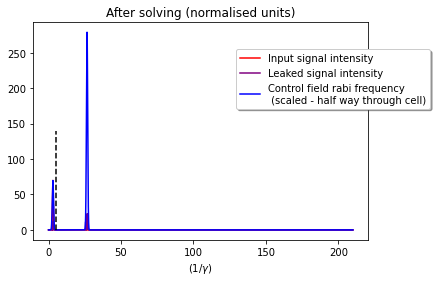

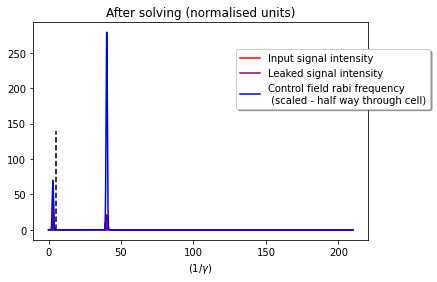

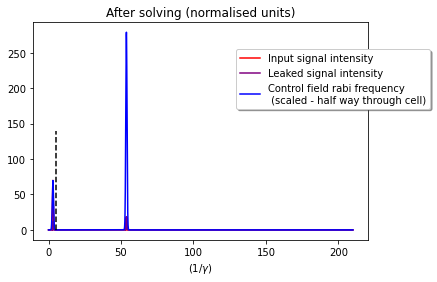

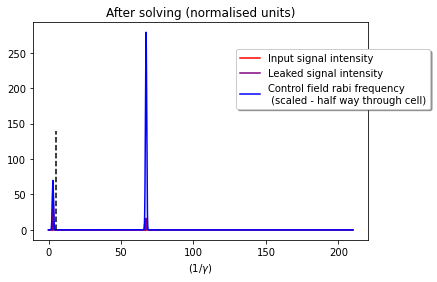

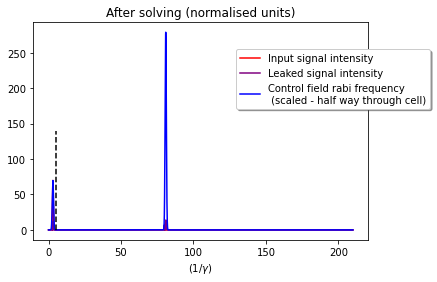

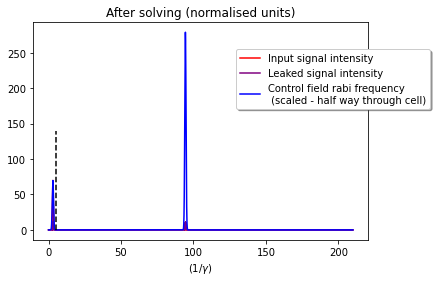

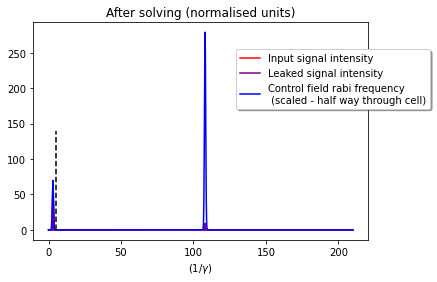

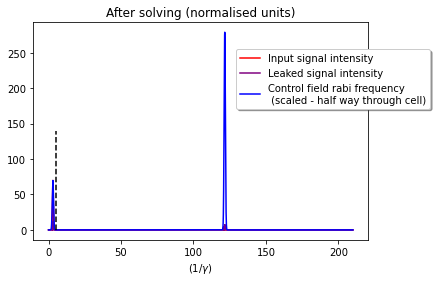

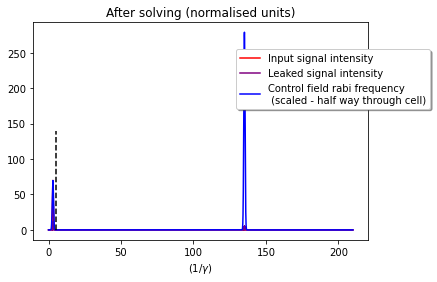

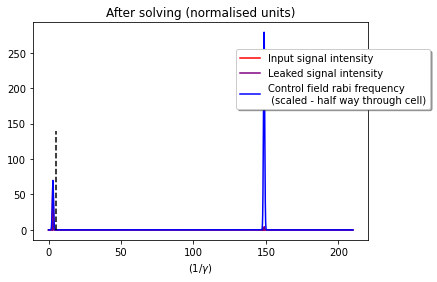

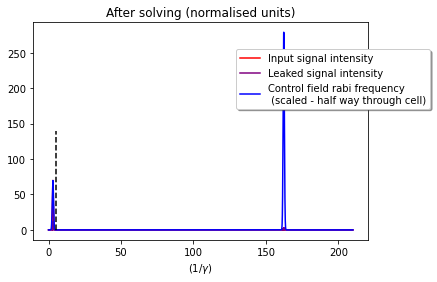

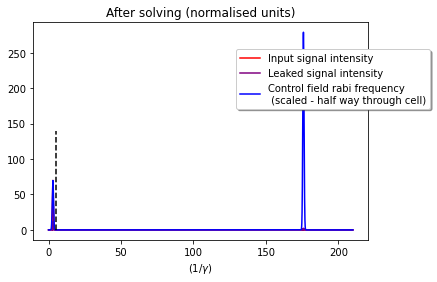

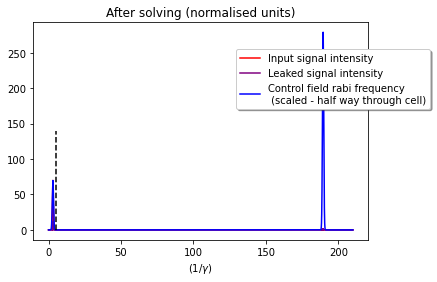

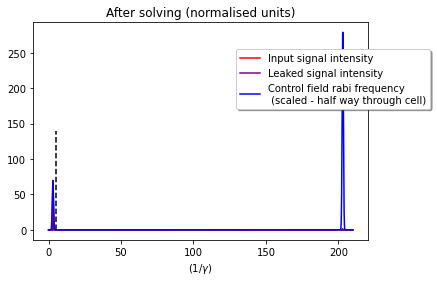

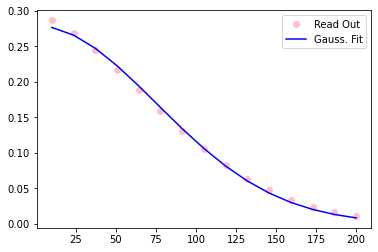

75.47770235507686


In [160]:
protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 210e-9
tbounds = np.array([0, tend])

m = 10000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 2e10

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)

tr_list = np.linspace(10e-9, 200e-9, 15)

retrieved_list = []

mcut = int((t0+2*tau)*m/(tend))

for tr in tr_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    retrieved_list.append(sol.retrieval_efficiency(sol.E, mcut, 0))

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
    plt.title('After solving (normalised units)')
    plt.xlabel('(1/$\gamma$)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()



fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[100, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

print(parameters[0])

In [164]:
# filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_3level_effvslifetime.txt'

# outlist = np.array([fit_x,  retrieved_list]).T.tolist()

# with open(filename, "w+") as outfile:
#     json.dump(outlist, outfile)

In [166]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_3level_effvslifetime.txt'

np.savetxt(filename, np.vstack((fit_x, retrieved_list)).T, delimiter=', ')

In [167]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_3level_effvslifetime_fit.txt'

np.savetxt(filename, np.vstack((fit_x, fit_y)).T, delimiter=', ')

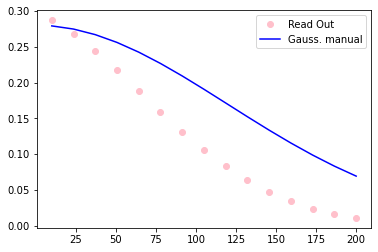

In [165]:
manual_y = gaussian_fit(fit_x, tDoppler*1e9, 0.28)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, manual_y, '-', label='Gauss. manual', color='blue')
plt.legend()
plt.show()

In [69]:
# correct gammaS

print(atom.gammas[1])

tLifetime = (1/atom.gammas[1])/2
print(tLifetime*1e9)

gammaS = (1/270e-9)/2
print(gammaS)

atom.gammas[1] = gammaS

3703703.7037037034
135.0
1851851.8518518517


In [70]:
tLifetime = (1/atom.gammas[1])/2
print(tLifetime*1e9)

270.0


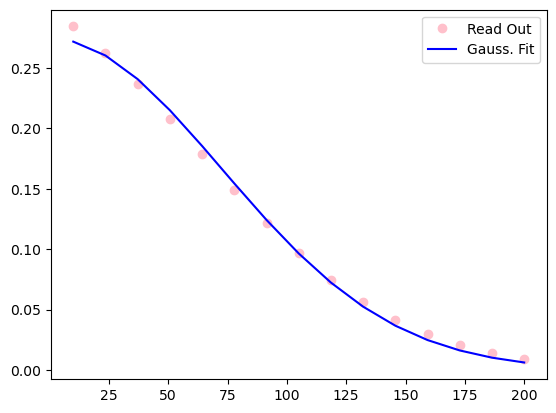

72.60652106467647


In [71]:
protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 210e-9
tbounds = np.array([0, tend])

m = 10000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 5e9
Omega_retrieve = 2e10

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)

tr_list = np.linspace(10e-9, 200e-9, 15)

retrieved_list = []

mcut = int((t0+2*tau)*m/(tend))

for tr in tr_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    retrieved_list.append(sol.retrieval_efficiency(sol.E, mcut, 0))

    # plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    # plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    # plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    # plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
    # plt.title('After solving (normalised units)')
    # plt.xlabel('(1/$\gamma$)')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    # plt.show()



fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[100, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

print(parameters[0])

In [168]:
fit_tw_3level = parameters[0]
fit_A_3level = parameters[1]
  
#fit_y_3level = gaussian_fit(fit_x, fit_tw_3level, fit_A_3level)

# Full level structure

In [2]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
import Optimiser as Opt
importlib.reload(Opt)
import timeit
from scipy.optimize import curve_fit

In [3]:
def gaussian_fit(t, tw, A):
    return A*np.exp(-pow(t,2)/(2*pow(tw,2)))

In [4]:
config = {"Hyperfine splitting": True, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 5, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [8]:
 len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq)

(1, 5, 4, 9)

In [5]:
atom.wq/1e6

array([ 43.995,  25.495,   0.895, -26.025])

In [6]:
1/atom.wq

array([ 2.27298557e-08,  3.92233771e-08,  1.11731844e-06, -3.84245917e-08])

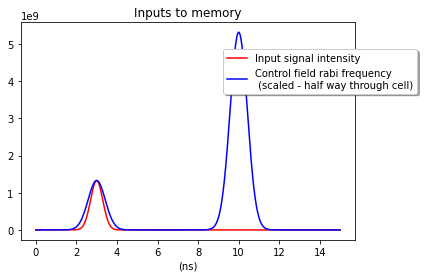

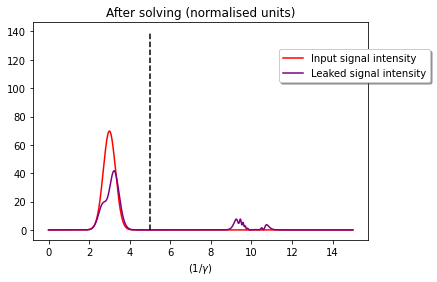

Storage Efficiency = 0.34893822506273603
Total Efficiency = 0.09410414316363139


In [7]:
protocol = 'ORCA'


OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 15e-9 #30e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([0, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 2*np.pi*2.5e9
Omega_retrieve = 2*np.pi*1e10
tr = 7e-9 #18e-9
control_pol = np.array([0, 1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

sol.pop = np.ones((len(atom.Fg), len(atom.mg)))/len(atom.mg) # distribute population between all ground state mF sublevels

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2)+pow(Einits[:, 1], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (max(pow(Einits[:, 0], 2)+pow(Einits[:, 1], 2))/Omega_store) * (Control_tp[:, 0]+Control_tp[:, 1]), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

# plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
# plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
# plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
# plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
# plt.title('After solving (normalised units)')
# plt.xlabel('(1/$\gamma$)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
# plt.show()

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)+pow(np.abs(sol.E[:, 0, 1]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2), color='purple', label='Leaked signal intensity')
#plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)+pow(np.abs(sol.E[:, 0, 1]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0) + sol.retrieval_efficiency(sol.E, mcut, 1)

print("Total Efficiency = " + str(eff))

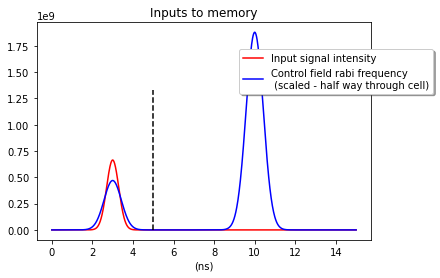

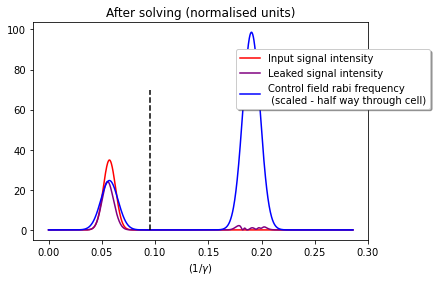

Storage Efficiency = 0.4822158138975371
Total Efficiency = 0.03386781486730837


In [131]:
protocol = 'ORCA'


OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 15e-9 #30e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 2*np.pi*2.5e9
Omega_retrieve = 2*np.pi*1e10
tr = 7e-9 #18e-9
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

In [132]:
sol.pop

array([[0., 0., 0., 0., 1.]])

In [133]:
nonzeroS = np.transpose(np.nonzero(sol.S[mcut, n//2, ..., 0]))
nonzeroS

array([[0, 4, 0, 4],
       [0, 4, 1, 2],
       [0, 4, 1, 4],
       [0, 4, 1, 6],
       [0, 4, 2, 2],
       [0, 4, 2, 4],
       [0, 4, 2, 6],
       [0, 4, 3, 0],
       [0, 4, 3, 2],
       [0, 4, 3, 4],
       [0, 4, 3, 6],
       [0, 4, 3, 8]], dtype=int64)

In [134]:
len(nonzeroS)

12

In [135]:
atom.mg

array([-2, -1,  0,  1,  2])

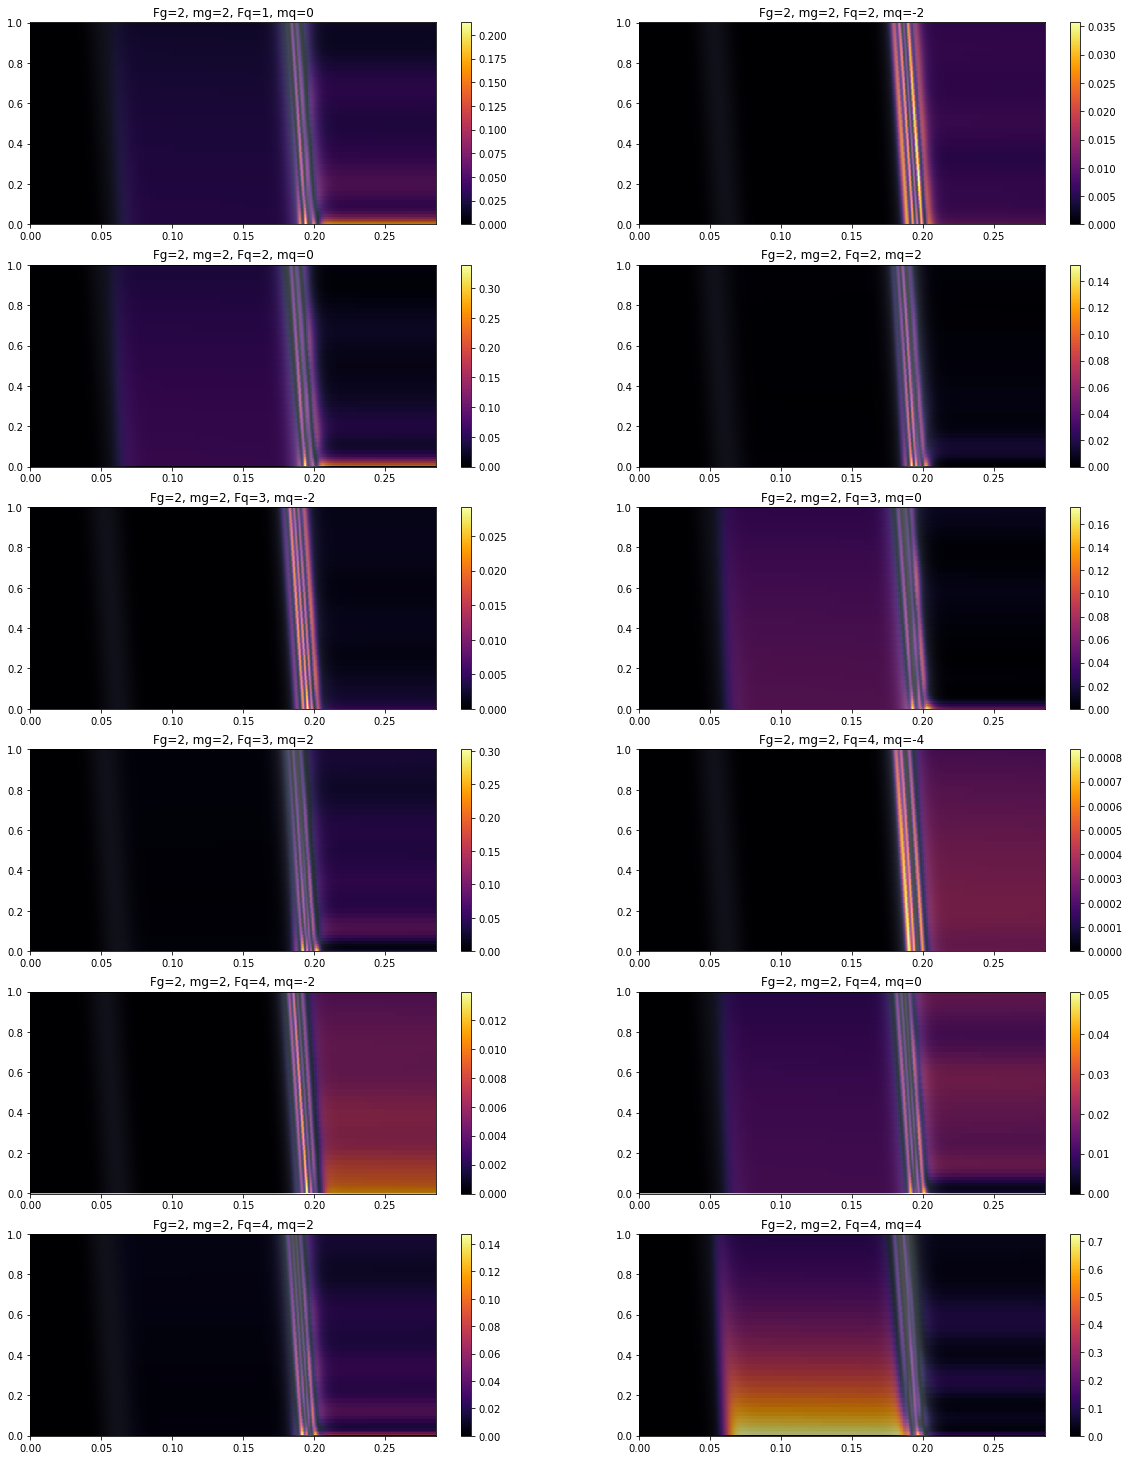

In [136]:
number_of_rows = len(nonzeroS)//2

nonzeroS_reshaped = nonzeroS.reshape(len(nonzeroS)//2, 2, 4)

fig, ax = plt.subplots(nrows=number_of_rows, ncols=2, figsize=(20,26))
colour = plt.get_cmap("inferno")

for row in range(0, number_of_rows):

    im = ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby,  pow(np.abs(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 0]) + [0])]),2).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 0])

    ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 0].set_title(str(nonzeroS_reshaped[row, 0]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 0, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 0, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 0, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 0].set_title(title)

    im = ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 1]) + [0])]),2).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 1])

    ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 1].set_title(str(nonzeroS_reshaped[row, 1]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 1, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 1, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 1, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 1].set_title(title)

plt.show()

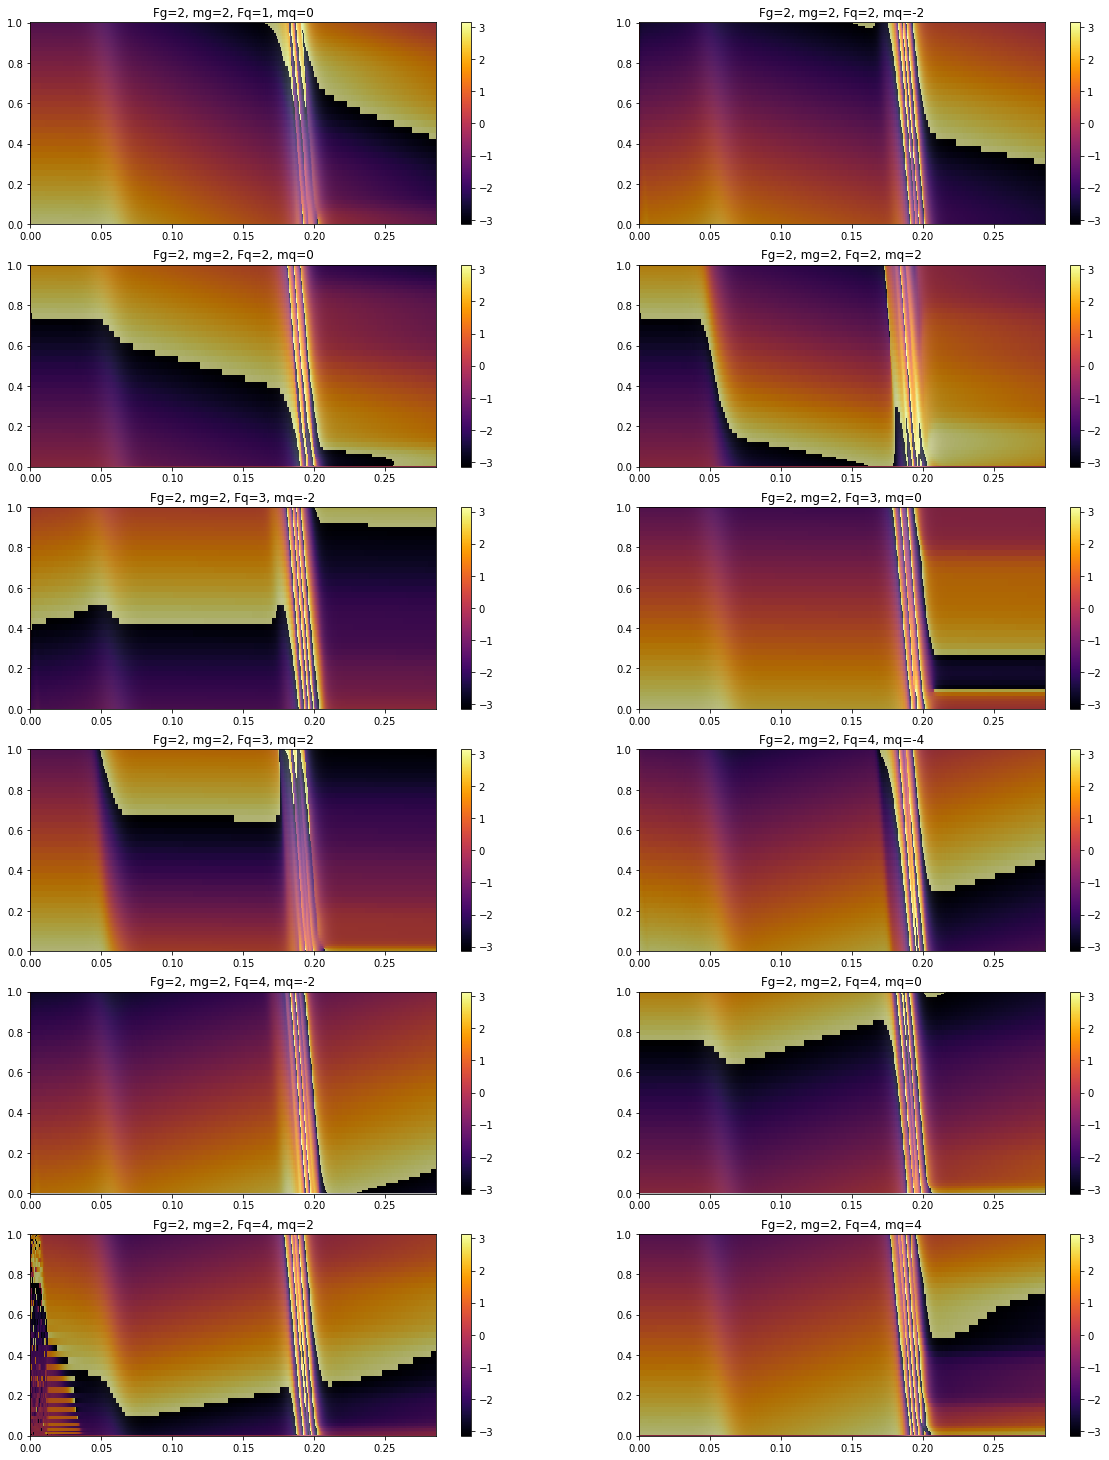

In [137]:
number_of_rows = len(nonzeroS)//2

nonzeroS_reshaped = nonzeroS.reshape(len(nonzeroS)//2, 2, 4)

fig, ax = plt.subplots(nrows=number_of_rows, ncols=2, figsize=(20,26))
colour = plt.get_cmap("inferno")

for row in range(0, number_of_rows):

    im = ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby,  np.angle(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 0]) + [0])]).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 0])

    ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 0].set_title(str(nonzeroS_reshaped[row, 0]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 0, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 0, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 0, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 0].set_title(title)

    im = ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, np.angle(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 1]) + [0])]).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 1])

    ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 1].set_title(str(nonzeroS_reshaped[row, 1]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 1, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 1, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 1, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 1].set_title(title)

plt.show()

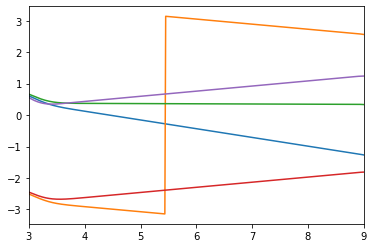

In [138]:
plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(nonzeroS_reshaped[0, 0]) + [0])]))
plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(nonzeroS_reshaped[1, 0]) + [0])]))
plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(nonzeroS_reshaped[2, 1]) + [0])]))
plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(nonzeroS_reshaped[4, 1]) + [0])]))
plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(nonzeroS_reshaped[5, 1]) + [0])]))
plt.xlim(3, 9)
plt.show()

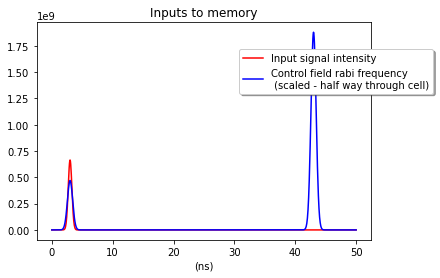

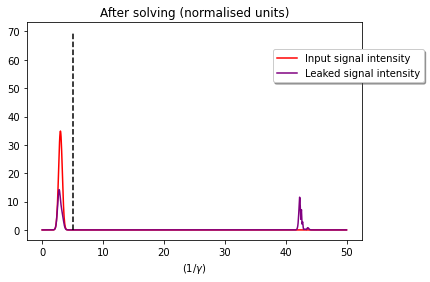

Storage Efficiency = 0.282285420829893
Total Efficiency = 0.0


In [139]:
protocol = 'ORCA'


OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 50e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([0, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 2*np.pi*2.5e9
Omega_retrieve = 2*np.pi*1e10
tr = 40e-9
control_pol = np.sqrt(1/2)*np.array([0, -1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

sol.pop = np.ones((len(atom.Fg), len(atom.mg)))/len(atom.mg) # distribute population between all ground state mF sublevels

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2)+pow(Einits[:, 1], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (max(pow(Einits[:, 0], 2)+pow(Einits[:, 1], 2))/Omega_store) * (np.abs(Control_tp[:, 0])+np.abs(Control_tp[:, 1])), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)+pow(np.abs(sol.E[:, 0, 1]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2), color='purple', label='Leaked signal intensity')
#plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)+pow(np.abs(sol.E[:, 0, 1]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

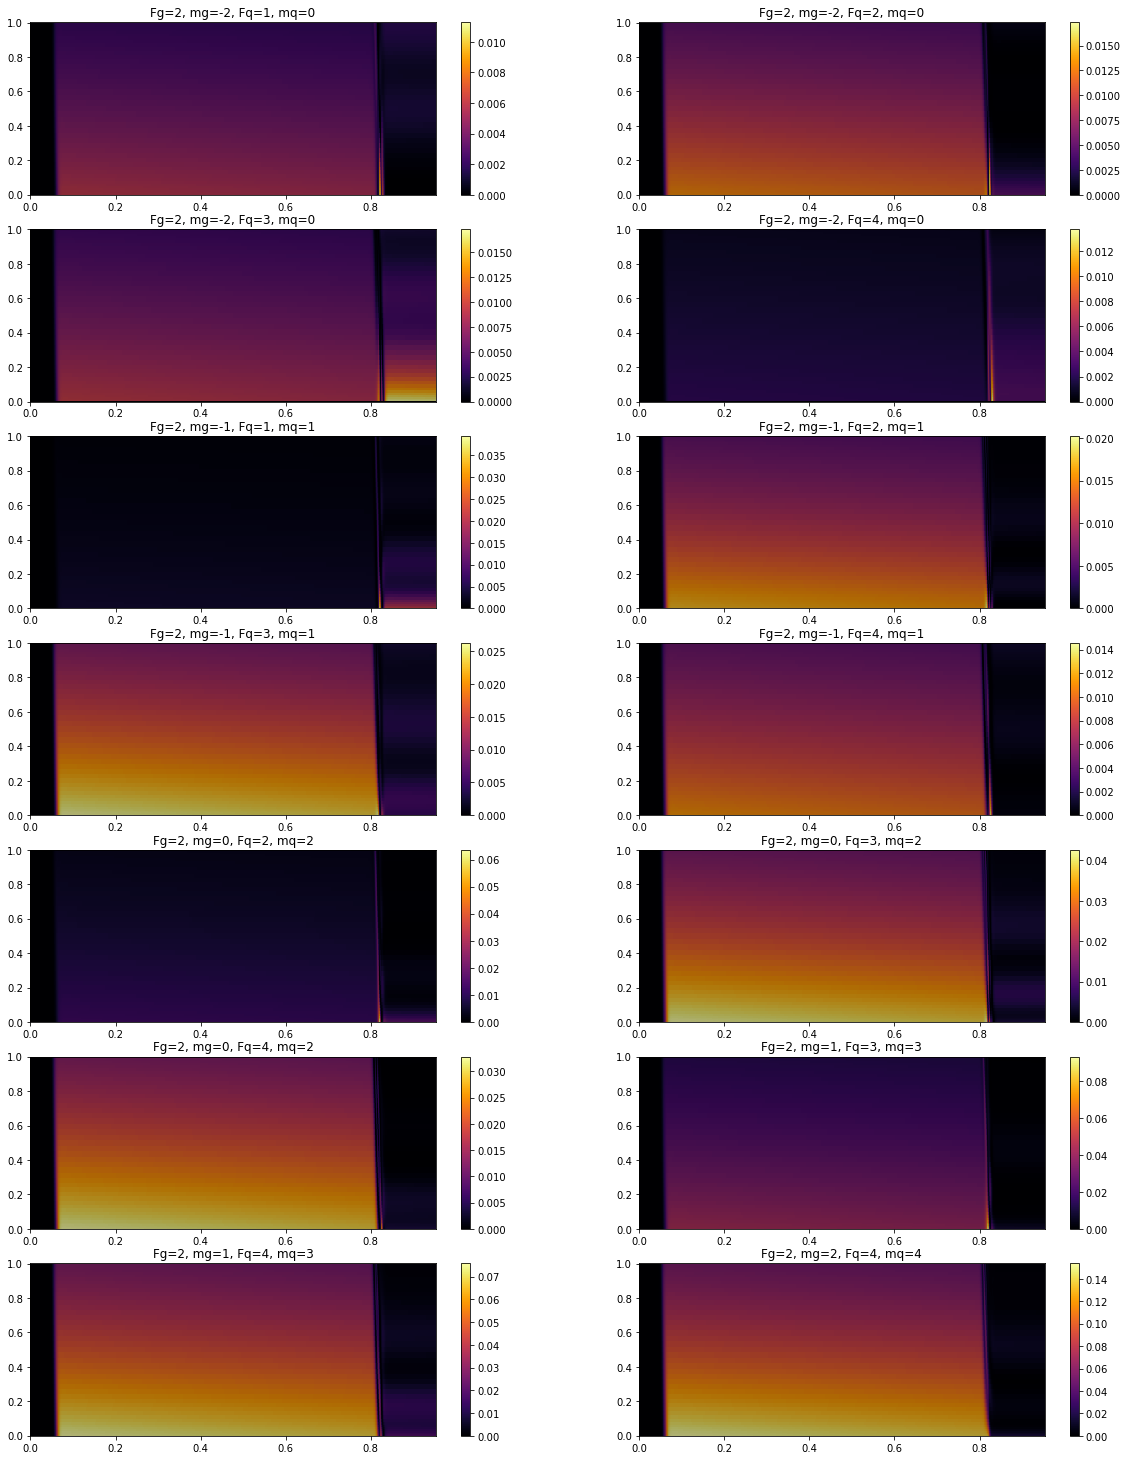

In [140]:
nonzeroS = np.transpose(np.nonzero(sol.S[mcut, n//2, ..., 0]))

number_of_rows = len(nonzeroS)//2

nonzeroS_reshaped = nonzeroS.reshape(len(nonzeroS)//2, 2, 4)

fig, ax = plt.subplots(nrows=number_of_rows, ncols=2, figsize=(20,26))
colour = plt.get_cmap("inferno")

for row in range(0, number_of_rows):

    im = ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby,  pow(np.abs(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 0]) + [0])]),2).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 0])

    ax[row, 0].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 0].set_title(str(nonzeroS_reshaped[row, 0]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 0, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 0, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 0, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 0].set_title(title)

    im = ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, pow(np.abs(sol.S[tuple([slice(0, -1), slice(0, -1)]  + list(nonzeroS_reshaped[row, 1]) + [0])]),2).T, 
                                cmap=colour)

    fig.colorbar(im, ax=ax[row, 1])

    ax[row, 1].pcolormesh(sol.tpoints, sol.zCheby, np.abs(Control_tzp(sol.t_grid, sol.z_grid)[:, :, 0]), cmap='bone', alpha=0.3)

    #ax[row, 1].set_title(str(nonzeroS_reshaped[row, 1]))

    mg_value = atom.mg[nonzeroS_reshaped[row, 1, 1]]
    Fq_value = int(atom.Fq[nonzeroS_reshaped[row, 1, 2]])
    mq_value = int(atom.mq[nonzeroS_reshaped[row, 1, 3]])

    title = f"Fg=2, mg={mg_value}, Fq={Fq_value}, mq={mq_value}"

    ax[row, 1].set_title(title)

plt.show()

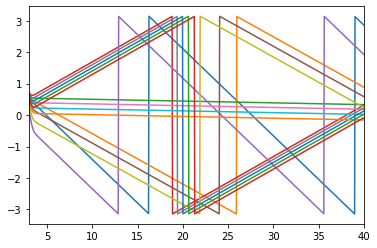

In [141]:
for index in nonzeroS:
    plt.plot(1e9*t[0:-1], np.angle(sol.S[tuple( [slice(0, -1), n//2] + list(index) + [0])]))
    plt.xlim(3, 40)

plt.show()

### Efficiency vs storage time

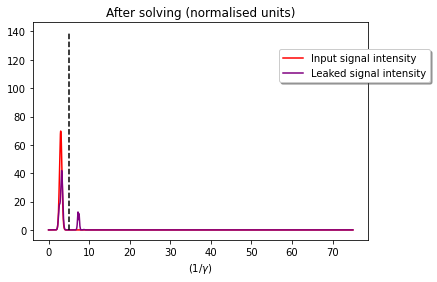

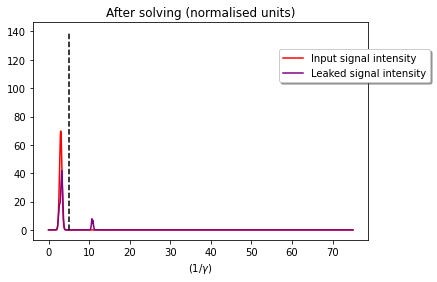

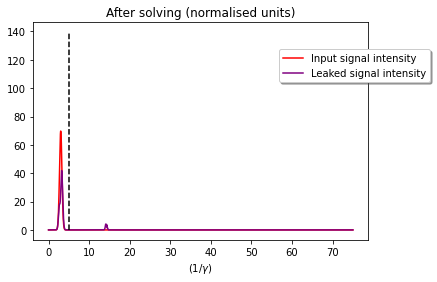

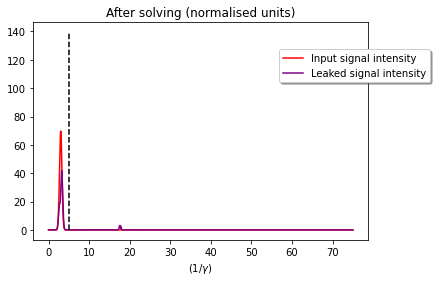

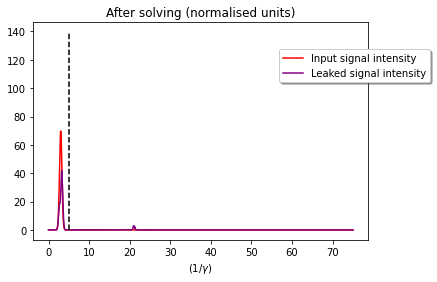

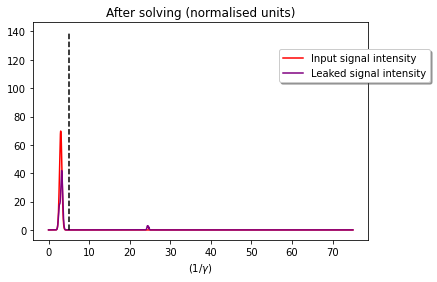

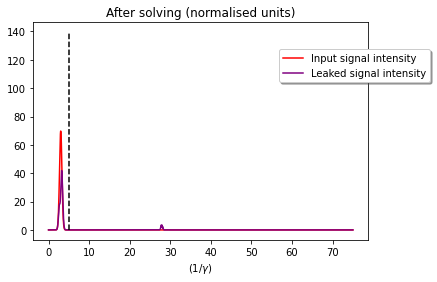

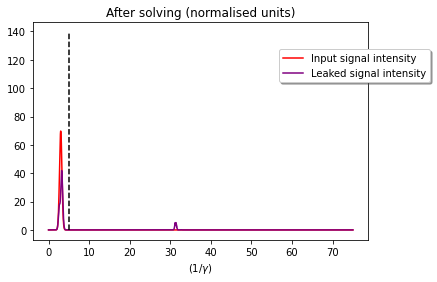

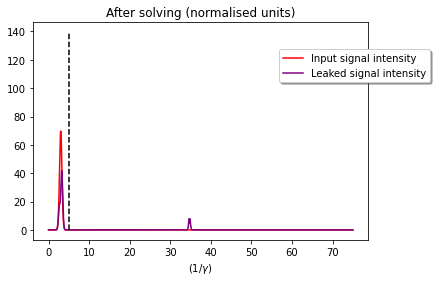

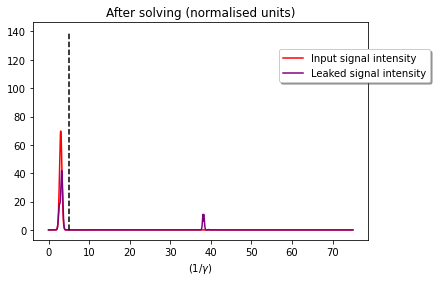

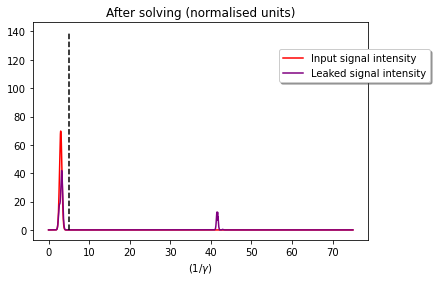

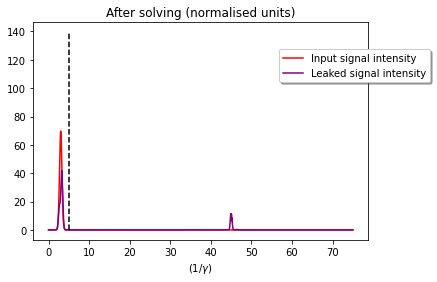

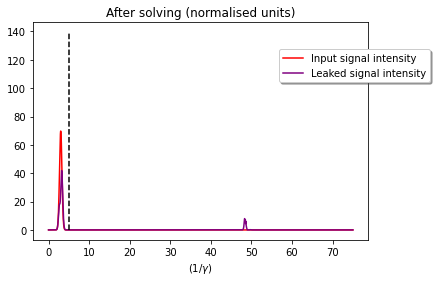

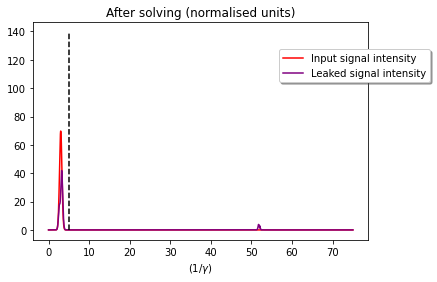

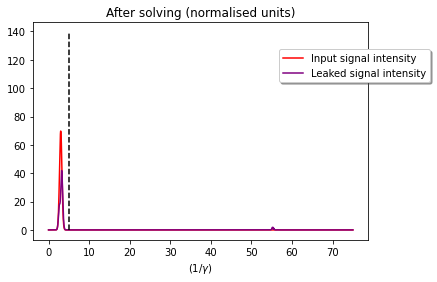

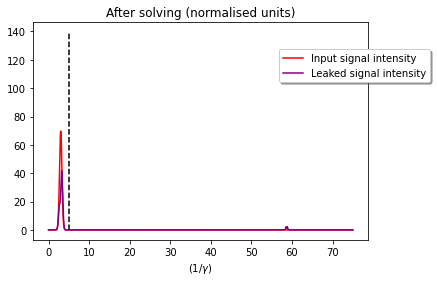

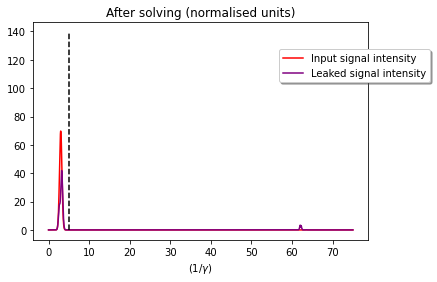

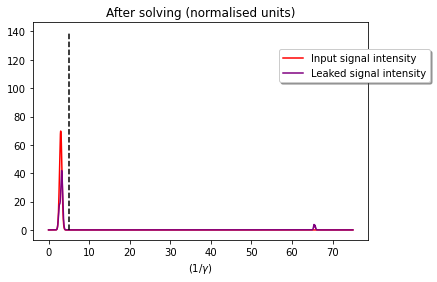

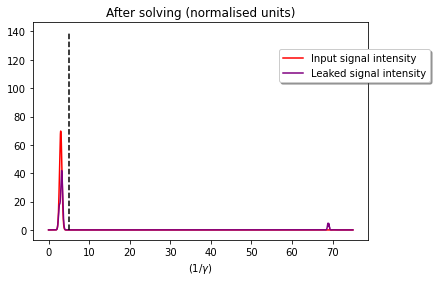

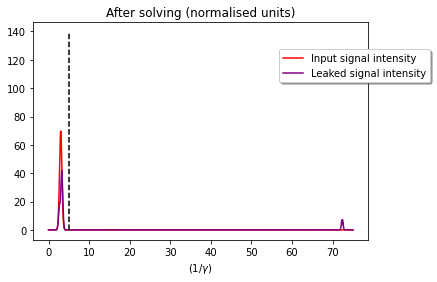

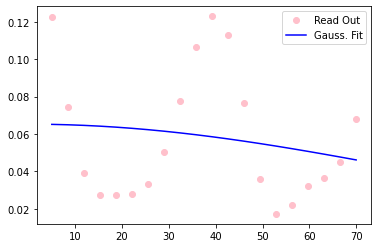

84.0759425508773


In [173]:
protocol = 'ORCA'

OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 75e-9 #210e-9
tbounds = np.array([0, tend])

m = 3000
t = np.linspace(0, tend, m)

photon_pol = np.array([0, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 2*np.pi*2.5e9
Omega_retrieve = 2*np.pi*1e10

control_pol = np.array([0, 1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)

tr_list = np.linspace(5e-9, 70e-9, 20)

retrieved_list = []
retrieved_list_L = []
retrieved_list_R = []

mcut = int((t0+2*tau)*m/(tend))

for tr in tr_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    sol.pop = np.ones((len(atom.Fg), len(atom.mg)))/len(atom.mg) # distribute population between all ground state mF sublevels

    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    retrieved_list.append(sol.retrieval_efficiency(sol.E, mcut, 0) + sol.retrieval_efficiency(sol.E, mcut, 1))
    retrieved_list_L.append(sol.retrieval_efficiency(sol.E, mcut, 0))
    retrieved_list_R.append(sol.retrieval_efficiency(sol.E, mcut, 1))

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)+pow(np.abs(sol.E[:, 0, 1]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2), color='purple', label='Leaked signal intensity')
    #plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)+pow(np.abs(sol.E[:, 0, 1]), 2)), color = 'black', linestyles='dashed')
    plt.title('After solving (normalised units)')
    plt.xlabel('(1/$\gamma$)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[100, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

print(parameters[0])

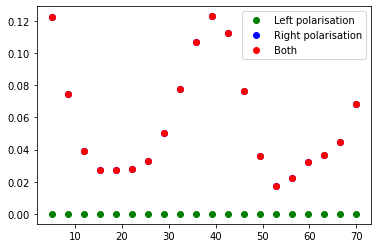

In [174]:
plt.plot(fit_x,  np.array(retrieved_list_L), 'o', label='Left polarisation', color='green')
plt.plot(fit_x,  np.array(retrieved_list_R), 'o', label='Right polarisation', color='blue')
plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Both', color='red')
plt.legend()
plt.show()

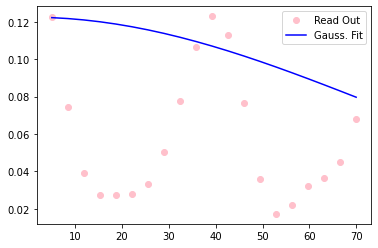

In [177]:
fit_y_3level = gaussian_fit(fit_x, fit_tw_3level, retrieved_list[0])

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y_3level, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

In [178]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_cold_full_manifold_effvslifetime.txt'

np.savetxt(filename, np.vstack((fit_x, retrieved_list)).T, delimiter=', ')

In [179]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_cold_manifold_effvslifetime_fit3level.txt'

np.savetxt(filename, np.vstack((fit_x, fit_y_3level)).T, delimiter=', ')

## Warm

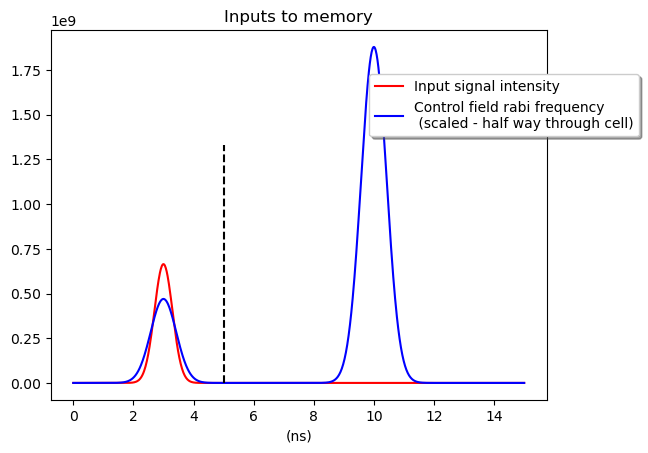

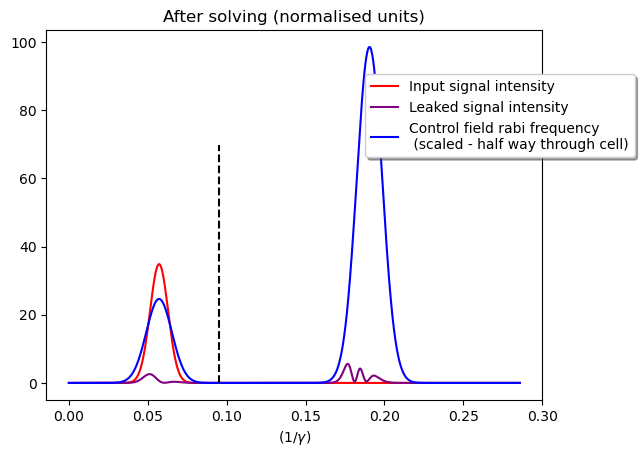

Storage Efficiency = 0.6029539306625906
Total Efficiency = 0.06878537058096819


In [24]:
protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 15e-9 #30e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 5e9
Omega_retrieve = 2e10
tr = 7e-9 #18e-9
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

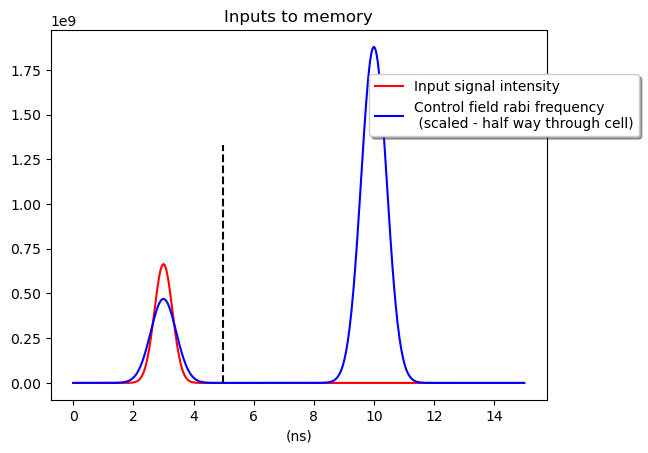

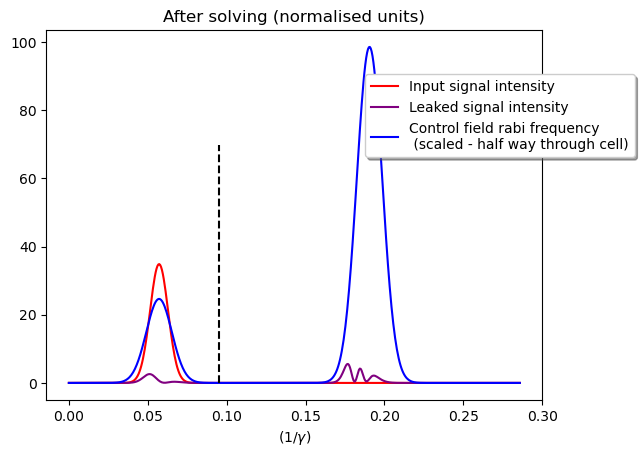

Storage Efficiency = 0.6026967390330769
Total Efficiency = 0.06874072730498537


In [27]:
protocol = 'ORCA'


OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 15e-9 #30e-9
tbounds = np.array([0, tend])

m = 500
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 5e9
Omega_retrieve = 2e10
tr = 7e-9 #18e-9
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

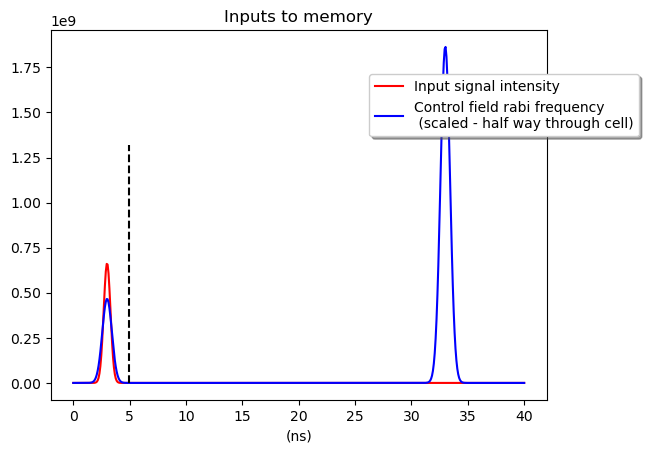

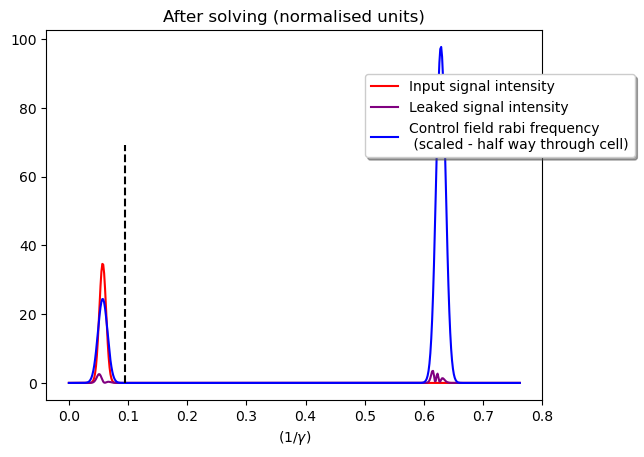

Storage Efficiency = 0.6005018321994466
Total Efficiency = 0.04487837481480575


In [28]:
protocol = 'ORCA'

OD = 125000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 40e-9
tbounds = np.array([0, tend])

m = 500
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 5e9
Omega_retrieve = 2e10
tr = 30e-9
control_pol = np.sqrt(1/2)*np.array([1, -1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)
Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

mcut = int((t0+2*tau)*m/(tend))

plt.plot(t*1e9, pow(Einits[:, 0], 2), color='red', label='Input signal intensity')
plt.plot(t*1e9, (pow(max(Einits[:, 0]), 2)/Omega_store) * Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(t[mcut]*1e9, 0, 2*max(pow(Einits[:, 0], 2)), color = 'black', linestyles='dashed')
plt.title('Inputs to memory')
plt.xlabel('(ns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

plt.plot(sol.tpoints, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(sol.tpoints, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(sol.tpoints, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.vlines(sol.tpoints[mcut], 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('(1/$\gamma$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()

eff = sol.storage_efficiency(sol.S, mcut)

print("Storage Efficiency = " + str(eff))

eff = sol.retrieval_efficiency(sol.E, mcut, 0)

print("Total Efficiency = " + str(eff))

## Efficiency vs storage time

Expect to see beating

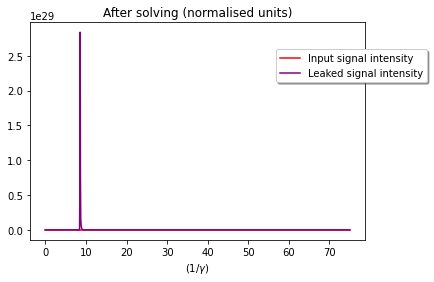

KeyboardInterrupt: 

In [181]:
protocol = 'ORCA'

OD = 5000
#BW = 2*np.pi*1e9
tau = 1e-9
n = 50
T = 273.15 + 100
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 3*tau
tend = 75e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([0, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

Omega_store = 2*np.pi*2.5e9
Omega_retrieve = 2*np.pi*1e10

control_pol = np.array([0, 1]) #should be normalised
Control_store = S.gaussian(t, t0, tau, Omega_store)

tr_list = np.linspace(5e-9, 70e-9, 20)

retrieved_list = []
retrieved_list_L = []
retrieved_list_R = []

mcut = int((t0+2*tau)*m/(tend))

for tr in tr_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    sol.pop = np.ones((len(atom.Fg), len(atom.mg)))/len(atom.mg) # distribute population between all ground state mF sublevels

    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    retrieved_list.append(sol.retrieval_efficiency(sol.E, mcut, 0) + sol.retrieval_efficiency(sol.E, mcut, 1))
    retrieved_list_L.append(sol.retrieval_efficiency(sol.E, mcut, 0))
    retrieved_list_R.append(sol.retrieval_efficiency(sol.E, mcut, 1))

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)+pow(np.abs(sol.E[:, 0, 1]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2) + pow(np.abs(sol.E[:, -1, 1]),2), color='purple', label='Leaked signal intensity')
    #plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)+pow(np.abs(sol.E[:, 0, 1]), 2)), color = 'black', linestyles='dashed')
    plt.title('After solving (normalised units)')
    plt.xlabel('(1/$\gamma$)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[100, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

print(parameters[0])

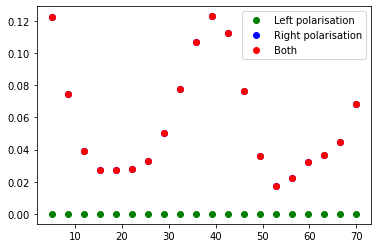

In [ ]:
plt.plot(fit_x,  np.array(retrieved_list_L), 'o', label='Left polarisation', color='green')
plt.plot(fit_x,  np.array(retrieved_list_R), 'o', label='Right polarisation', color='blue')
plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Both', color='red')
plt.legend()
plt.show()

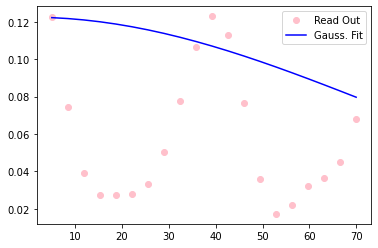

In [ ]:
fit_y_3level = gaussian_fit(fit_x, fit_tw_3level, retrieved_list[0])

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y_3level, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

In [ ]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_full_manifold_effvslifetime.txt'

np.savetxt(filename, np.vstack((fit_x, retrieved_list)).T, delimiter=', ')

In [ ]:
filename = 'C:\\Users\\44752\\OneDrive - Imperial College London\\Documents\\GitHub\\LORCA_report\\ORCA_warm_full_manifold_effvslifetime_fit3level.txt'

np.savetxt(filename, np.vstack((fit_x, fit_y_3level)).T, delimiter=', ')

# Optimise

In [1]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
import Optimiser as Opt
importlib.reload(Opt)
import timeit
from scipy.optimize import curve_fit
import json

In [2]:
import AtomicConstants as AC
importlib.reload(AC)

# Make atom class

config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 5, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [10]:
# Want ~100% storage

protocol = 'ORCA'

OD = 6250.55192527397
BW = 2*np.pi*5689.866029018293e6
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

m = 800
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

control_pol = np.array([1, 0])

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

A = 1e-3*detuning/np.sqrt(OD * 3*tau) / sol.gamma
print(A)
Control_init1 = (S.gaussian(t, t0, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Control_init2 = (S.gaussian(t, t0, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Controls = [Control_init, Control_init2]
step_size = 500
tol = 0.001

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Controls, step_size, tol,
                                    adaptive_step_size=True)

1.640620749802465


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

In [5]:
# Want ~100% storage

protocol = 'ORCA'

OD = 1389.4954943731375
BW = 2*np.pi*1030.2040806397147e6
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

m = 800
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

control_pol = np.array([1, 0])

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

A = 1e-3*detuning/np.sqrt(OD * 3*tau) / sol.gamma
print(A)
Control_init = np.full(sol.m, sol.gamma)[:, None] * control_pol[None, :]
Control_init2 = (S.gaussian(t, tend/2, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Controls = [Control_init, Control_init2]
step_size = 500
tol = 0.01

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Controls, step_size, tol,
                                    adaptive_step_size=True)

1458.7732531038896


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

In [5]:
# Want ~100% storage

protocol = 'ORCA'

OD = 100
BW = 2*np.pi*20e6
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
n = 50
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

m = 800
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

control_pol = np.array([1, 0])

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

A = 1e-3*detuning/np.sqrt(OD * 3*tau) / sol.gamma
Control_init = np.full(sol.m, sol.gamma)[:, None] * control_pol[None, :]
Control_init2 = (S.gaussian(t, tend/2, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Controls = [Control_init, Control_init2]
step_size = 500
tol = 0.01

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Controls, step_size, tol,
                                    adaptive_step_size=True)

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

KeyboardInterrupt: 

In [5]:
# Want ~100% storage

protocol = 'ORCA'

OD = 100
BW = 20e6
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
n = 75
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

control_pol = np.array([1, 0])

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

A = 1e-3*detuning/np.sqrt(OD * 3*tau) / sol.gamma
Control_init = np.full(sol.m, 10*sol.gamma)[:, None] * control_pol[None, :]
Control_init2 = (S.gaussian(t, tend/2, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Controls = [Control_init, Control_init2]
step_size = 2000
tol = 0.01

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Controls, step_size, tol,
                                    adaptive_step_size=True)

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

## Full manifold

In [6]:
import AtomicConstants as AC
importlib.reload(AC)

# Make atom class

config = {"Hyperfine splitting": True, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 5, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [7]:
atom.wj

array([-3.0207375e+08, -2.2985175e+08, -7.2911250e+07,  1.9374075e+08])

In [8]:
np.tile(atom.wj, (1, len(atom.wj)))

array([[-3.0207375e+08, -2.2985175e+08, -7.2911250e+07,  1.9374075e+08,
        -3.0207375e+08, -2.2985175e+08, -7.2911250e+07,  1.9374075e+08,
        -3.0207375e+08, -2.2985175e+08, -7.2911250e+07,  1.9374075e+08,
        -3.0207375e+08, -2.2985175e+08, -7.2911250e+07,  1.9374075e+08]])

In [11]:
np.tile(atom.wj, (len(atom.wj), 1)).T

array([[-3.0207375e+08, -3.0207375e+08, -3.0207375e+08, -3.0207375e+08],
       [-2.2985175e+08, -2.2985175e+08, -2.2985175e+08, -2.2985175e+08],
       [-7.2911250e+07, -7.2911250e+07, -7.2911250e+07, -7.2911250e+07],
       [ 1.9374075e+08,  1.9374075e+08,  1.9374075e+08,  1.9374075e+08]])

In [13]:
np.tile(atom.wj, (len(atom.wj), 1)) - np.tile(atom.wj, (len(atom.wj), 1)).T

array([[ 0.000000e+00,  7.222200e+07,  2.291625e+08,  4.958145e+08],
       [-7.222200e+07,  0.000000e+00,  1.569405e+08,  4.235925e+08],
       [-2.291625e+08, -1.569405e+08,  0.000000e+00,  2.666520e+08],
       [-4.958145e+08, -4.235925e+08, -2.666520e+08,  0.000000e+00]])

In [21]:
test = np.ones((50, 4, 7, 4, 7, 30) , dtype=complex)
test.shape

(50, 4, 7, 4, 7, 30)

In [ ]:
test[:, ]

In [25]:
arr = np.ones((50, 4, 7, 4, 7, 30) , dtype=complex)

for i in range(4):
    for j in range(7):
        arr[:, i, j, i, j, :] = 0

In [26]:
# Create an array of ones with the specified shape and dtype
arr2 = np.ones((50, 4, 7, 4, 7, 30), dtype=complex)

# Create index arrays for i and j
i_indices, j_indices = np.indices((4, 7))

# Use advanced indexing to set the elements to 0
arr2[:, i_indices, j_indices, i_indices, j_indices, :] = 0

In [28]:
(arr == arr2).all()

True

In [51]:
# Want ~100% storage

protocol = 'ORCA'

OD = 5000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
n = 75
T = 0
vno = 1
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.sqrt(1/2)*np.array([1, 1]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

control_pol = np.sqrt(1/2)*np.array([1, -1])

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

A = 1e-3*detuning/np.sqrt(OD * 3*tau) / sol.gamma
Control_init = np.full(sol.m, sol.gamma)[:, None] * control_pol[None, :]
Control_init2 = (S.gaussian(t, tend/2, tau, A*sol.gamma))[:, None] * control_pol[None, :]
Controls = [Control_init, Control_init2]
step_size = 2000
tol = 0.01

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Controls, step_size, tol,
                                    adaptive_step_size=True)

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…